<a href="https://colab.research.google.com/github/hendriansofu/LSTM-Long-Short-Term-Memory-/blob/main/1layer_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds
import random
import gensim
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [ ]:
df = pd.read_csv('sentiment_labeled_data.csv')

## **Word Embedding**

In [ ]:
sentences = [text.split() for text in df['stemmed_text']]  # Mengubah string menjadi list of tokens

# Latih model Word2Vec pada teks yang ada
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4, sg=0)

# Tokenisasi teks untuk padding dan konversi ke sekuens numerik
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['stemmed_text'])  # Fit tokenizer pada teks yang sudah ter-tokenisasi
sequences = tokenizer.texts_to_sequences(df['stemmed_text'])  # Konversi teks ke sekuens numerik

# Pad sequences
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length)

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

print("Embedding Matrix:")
print(embedding_matrix)


Embedding Matrix:
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.36154318 -1.51168232  1.3580767  ...  0.27687354 -1.43852537
  -0.60805411]
 [ 1.28965535 -0.3005918   0.4703183  ...  1.09731061 -0.04561097
  -2.63947452]
 ...
 [ 0.33488403  0.47644604  1.36949242 ... -0.45816522 -0.93519305
   0.29456591]
 [ 1.36716228  0.58084084 -0.12320462 ... -0.2620012  -2.15575984
   2.17920771]
 [ 0.57082109  0.77037424  0.79085059 ... -0.60590462 -0.43529969
  -0.3775394 ]]


Pelatihan Model

In [ ]:
# Buat model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=False),
    LSTM(100, return_sequences=True),
    Dropout(0.9),  # Tingkatkan dropout
    Dense(1, activation='sigmoid')
])

# Optimizer dengan learning rate yang lebih rendah
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['sentiment_binary'], test_size=0.3, random_state=42)

# Print summary untuk memverifikasi arsitektur model
model.summary()

# Train the model tanpa early stopping
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Menampilkan hasil akhir pelatihan
print("Model training completed.")
print("Final validation accuracy:", history.history['val_accuracy'][-1])
print("Final training loss:", history.history['loss'][-1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 47, 300)           3145200   
                                                                 
 lstm_1 (LSTM)               (None, 47, 100)           160400    
                                                                 
 dropout_1 (Dropout)         (None, 47, 100)           0         
                                                                 
 dense_1 (Dense)             (None, 47, 1)             101       
                                                                 
Total params: 3305701 (12.61 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 3145200 (12.00 MB)
_________________________________________________________________
Epoch 1/5
96/96 [==============================] - 14s 110ms/step - loss: 0.6756 - accuracy: 0.6161 - val_loss: 0.6466 - val_accuracy: 0.6346

Training history plot saved as 'training_history.png'


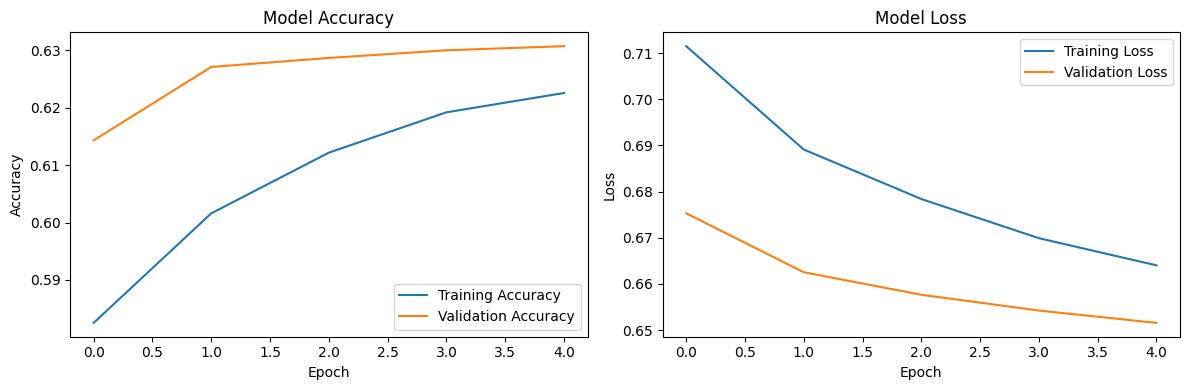

In [ ]:
# Plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
print("Training history plot saved as 'training_history.png'")

